In [1]:
import torch
# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

if cuda_available:
    # Get the number of GPUs available
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")

    # Get the name of each GPU
    for i in range(num_gpus):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {gpu_name}")

    # Get the current GPU memory usage
    for i in range(num_gpus):
        gpu_memory_allocated = torch.cuda.memory_allocated(i)
        gpu_memory_reserved = torch.cuda.memory_reserved(i)
        print(f"GPU {i} memory allocated: {gpu_memory_allocated / (1024 ** 3):.2f} GB")
        print(f"GPU {i} memory reserved: {gpu_memory_reserved / (1024 ** 3):.2f} GB")
else:
    print("CUDA is not available.")

CUDA available: True
Number of GPUs available: 2
GPU 0: NVIDIA GeForce RTX 2070
GPU 1: NVIDIA GeForce RTX 2070
GPU 0 memory allocated: 0.00 GB
GPU 0 memory reserved: 0.00 GB
GPU 1 memory allocated: 0.00 GB
GPU 1 memory reserved: 0.00 GB


In [2]:
import sys
import os
import pickle
import logging
import numba
import matplotlib
import matplotlib.pyplot as plt
logging.getLogger('matplotlib.font_manager').disabled = True
numba_logger = logging.getLogger('numba')
numba_logger.setLevel(logging.WARNING)

matplotlib_logger = logging.getLogger('matplotlib')
matplotlib_logger.setLevel(logging.WARNING)

# Add the src directory to sys.path
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(src_path)

from src.IndependentSteps import Pycromanager2NativeDataType, FFF2NativeDataType, Make_Output_Dir_JF, Make_Analysis_Dir_JF, \
                                    ConsolidateImageShapes, TrimZSlices, AutomaticSpotDetection_JF

from src.SequentialSteps import CellSegmentationStepClass_JF, BIGFISH_SpotDetection, SimpleCellposeSegmentaion, Calculate_BIGFISH_Threshold

from src.FinalizationSteps import Save_Outputs, Save_Images, Save_Parameters, Save_Masks, return_to_NAS, remove_local_data_but_keep_h5

from src.Parameters import Parameters, Experiment, Settings, ScopeClass, DataContainer

from src.GeneralOutput import OutputClass

from src.Displays import Display

from src.GUI import GUI, StepGUI

from src.Pipeline import Pipeline

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7


In [3]:
# This is how you initialize the parameters
scope = ScopeClass() 
data = DataContainer() # you can also initialize these with parameters, but it is not necessary due to defaults
settings = Settings(name='test') # you also must give a name for the analysis your are doing
experiment = Experiment()

# experiment.initial_data_location = ['smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_0min_20220224',
#                                     'smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_10min_20220224']
experiment.initial_data_location = None
data.local_dataset_location = [r'C:\Users\formanj\GitHub\FISH_Processing\Demos\DUSP1_Dex_10min_20220224', r'C:\Users\formanj\GitHub\FISH_Processing\Demos\DUSP1_Dex_0min_20220224']
experiment.FISHChannel = 0
experiment.nucChannel = 2
experiment.cytoChannel = 1
experiment.voxel_size_z = 500

settings.num_chunks_to_run = 1 # this is the limit to how many chunks you want to run and it will stop after that

scope.spot_yx = 130
scope.spot_z = 360
scope.voxel_size_yx = 100

In [4]:
# You can see the parameters in each of these classes by printing them
print(experiment)
print(settings)
print(scope)
print(data)


Experiment:
initial_data_location: None 
index_dict: None 
nucChannel: 2 
cytoChannel: 1 
FISHChannel: 0 
voxel_size_z: 500 
independent_params: None 
kwargs: None 
timestep_s: None 

Settings:
name: test 
return_data_to_NAS: True 
NUMBER_OF_CORES: 4 
save_files: True 
num_chunks_to_run: 1 
download_data_from_NAS: True 
connection_config_location: c:\Users\formanj\GitHub\FISH_Processing\config_nas.yml 
share_name: share 
display_plots: True 
load_in_mask: False 

ScopeClass:
voxel_size_yx: 100 
spot_z: 360 
spot_yx: 130 
microscope_saving_format: pycromanager 

DataContainer:
local_dataset_location: ['C:\\Users\\formanj\\GitHub\\FISH_Processing\\Demos\\DUSP1_Dex_10min_20220224', 'C:\\Users\\formanj\\GitHub\\FISH_Processing\\Demos\\DUSP1_Dex_0min_20220224'] 
h5_file: None 
total_num_chunks: None 
images: None 
masks: None 



In [5]:
# you can get all of the parameters that you have initialized by calling get_parameters
Parameters.get_parameters()

{'voxel_size_yx': 100,
 'spot_z': 360,
 'spot_yx': 130,
 'microscope_saving_format': 'pycromanager',
 'local_dataset_location': ['C:\\Users\\formanj\\GitHub\\FISH_Processing\\Demos\\DUSP1_Dex_10min_20220224',
  'C:\\Users\\formanj\\GitHub\\FISH_Processing\\Demos\\DUSP1_Dex_0min_20220224'],
 'h5_file': None,
 'total_num_chunks': None,
 'images': None,
 'masks': None,
 'name': 'test',
 'return_data_to_NAS': True,
 'NUMBER_OF_CORES': 4,
 'save_files': True,
 'num_chunks_to_run': 1,
 'download_data_from_NAS': True,
 'connection_config_location': 'c:\\Users\\formanj\\GitHub\\FISH_Processing\\config_nas.yml',
 'share_name': 'share',
 'display_plots': True,
 'load_in_mask': False,
 'initial_data_location': None,
 'index_dict': None,
 'nucChannel': 2,
 'cytoChannel': 1,
 'FISHChannel': 0,
 'voxel_size_z': 500,
 'independent_params': None,
 'kwargs': None,
 'timestep_s': None}

In [6]:
# You can check that all the manditory parameters are set by calling validate
Parameters.validate()

# this will give you two type of response, one if its a warning like this one below
# this is just a warning because you may not have a cytoChannel,
# but it is not manditory so the pipeline will still run
# there are also errors that will stop the pipeline from running

['C:\\Users\\formanj\\GitHub\\FISH_Processing\\Demos\\DUSP1_Dex_10min_20220224', 'C:\\Users\\formanj\\GitHub\\FISH_Processing\\Demos\\DUSP1_Dex_0min_20220224']


The next fundamental class is the step class.  
These are intellegentlty written wrappers for a image processing step.  
Alone they are nothing unique because they just duplicate already made functialility.  
However, they are used to generate standardized outputs that can feed into other steps.  
For instance spot detection is a ongoing field of research and new ones are being made.  
So being able to substitute in new spot detection algorithems and have them integrate directly into  
trackpy is a useful feature, and is what this package aims to do.

In [7]:
# If you want this to load in the previous made masks
settings.load_in_mask = True
FFF2NativeDataType().run() # this will run the step

Overwriting independent_params in Experiment
Adding leftover kwargs to Settings
Adding position_indexs to Settings


In [8]:
# if you would like to remove the original data from disk
remove_local_data_but_keep_h5().run()

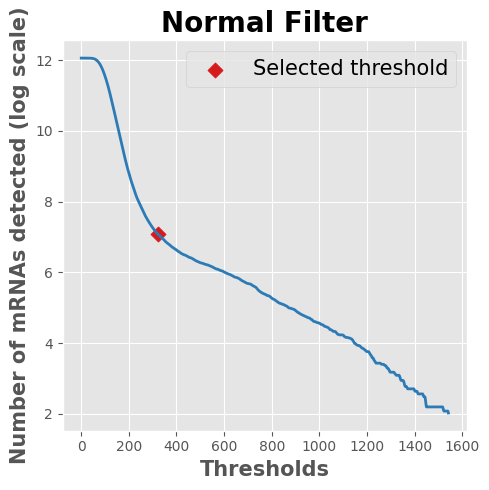

In [ ]:
Calculate_BIGFISH_Threshold().run()

In [ ]:
# You can see the parameters in each of these classes by printing them
print(experiment)
print(settings)
print(scope)
print(data)
